In [1]:
import numpy as np
import xarray as xr
import gsw
import time 
from datetime import datetime
from matplotlib.colors import LogNorm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy
import cartopy.crs as ccrs 
import cmocean
from scipy.interpolate import interp1d 
import scipy.ndimage as si
from scipy.fftpack import fft
from tqdm.notebook import tqdm
import pickle 
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# load file 
filename = ('/Users/jakesteinberg/Documents/CPT/j2_filtered.nc')
j2_filtered = xr.open_dataset(filename)
total_ke = j2_filtered['total_ke'].data
filtered_ke = j2_filtered['filtered_ke'].data
eke = j2_filtered['eke'].data
frac_year = j2_filtered['frac_year'].data
lon_bin_c = j2_filtered.lon.longitude.data
lat_bin_c = j2_filtered.lat.latitude.data
coarsening_factors = j2_filtered.filter_fac.filter_fac.data
s_i = j2_filtered['month_bins'].data

In [3]:
# load climatology
f_argo_pe = '/Users/jakesteinberg/Documents/CPT/Argo/Argo_PE_APEConversion7_RG_MIMOC.nc'
argo_pe = xr.open_dataset(f_argo_pe)
pe_lon = argo_pe.RGlon.RGlongitude.data
pe_lat = argo_pe.RGlat.RGlatitude.data
# pe = argo_pe['pe'].data
pe_rate = argo_pe['ape_rate_RG'].data

In [4]:
# global parameters/fields 
hor_grid_spacing = 20.0
lon_bins = np.arange(0,361)
lat_bins = np.arange(-70,71)
lon_w = 0
lon_e = 360
lat_s = -65
lat_n = 65
month_labels = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
# colors = ['#191970', '#DAA520', '#808000', '#8B0000', 'c', 'm']
# colors = ['#79B791', '#086788', '#F0C808', '#DC493A', '#664147', 'm', '#FF8C00']
colors = ['#086788', '#F0C808', '#79B791', '#DC493A', 'c', 'm', '#FF8C00'] # #664147
order = ['Eastern N. Pac.', 'Kuroshio', 'Indian', 'N. Atl.', 'ACC', 'Gulf Stream','Eastern S. Pac.']
location = np.array([[210, 214, 35, 39], [148, 152, 28, 32], [90, 94, -21, -17], \
                     [326, 330, 38, 42], [310, 314, -52, -48], [290, 294, 30, 34], [248, 252, -40, -36]])

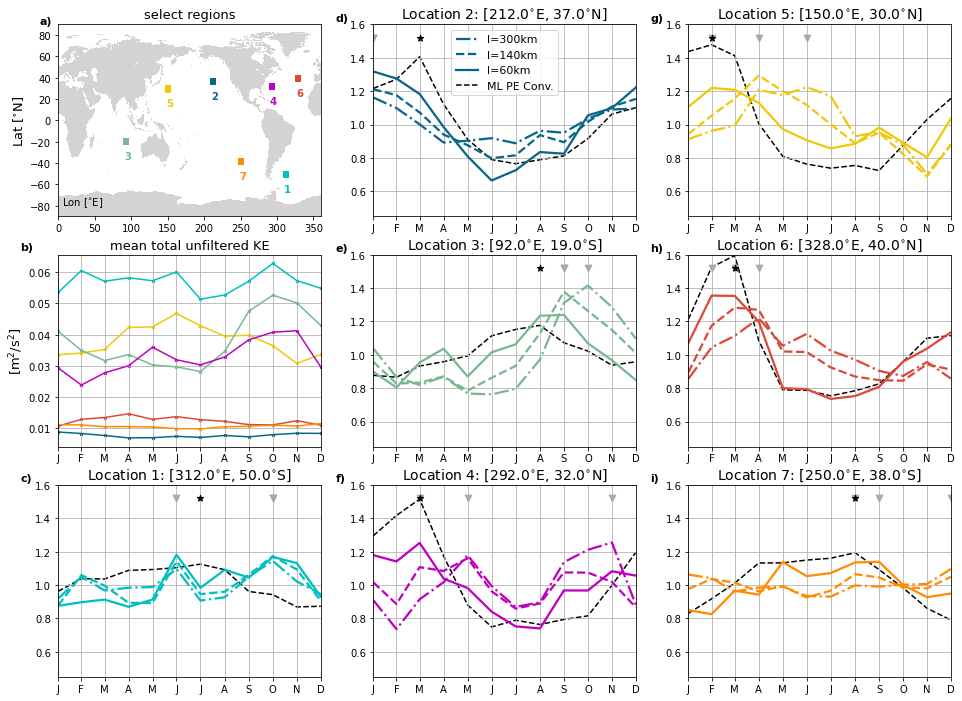

In [11]:
# seasonality in EKE 
x4 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/bathymetry_gebco_2020/landmask2.nc') 
land_cmap = plt.cm.get_cmap('viridis')
land_cmap.set_over('#D3D3D3') #FFDEAD
land_cmap.set_under('w')
# ---
f, ax = plt.subplots(3, 3, figsize = (16, 12))
ax[0,0].pcolor(x4['lon'].values, x4['lat'].values, x4['landMask'].values, vmin=0.2, vmax=0.3, cmap=land_cmap)
in_lon = []
in_lat = []
in_lon_pe = []
in_lat_pe = []
loci = [2,5,3,6,1,4,7]
for i in [0,1,2,3,4,5,6]:  # range(len(order[0:5])):
    this_lon0 = location[i, 0] #90   # 210
    this_lon1 = location[i, 1] #94   # 214
    this_lat0 = location[i, 2] #-22  # 35
    this_lat1 = location[i, 3] #-18  # 39
    ax[0,0].plot([this_lon0, this_lon1], [this_lat0, this_lat0], color=colors[i], linewidth=3)
    ax[0,0].plot([this_lon0, this_lon1], [this_lat1, this_lat1], color=colors[i], linewidth=3)
    ax[0,0].plot([this_lon0, this_lon0], [this_lat0, this_lat1], color=colors[i], linewidth=3)
    ax[0,0].plot([this_lon1, this_lon1], [this_lat0, this_lat1], color=colors[i], linewidth=3)
    # if i < 4:
    ax[0,0].text(this_lon0, this_lat0 - 15, loci[i], fontsize=10, color=colors[i], fontweight='bold')
    in_lon.append(np.where((lon_bin_c > this_lon0) & (lon_bin_c < this_lon1))[0])
    in_lat.append(np.where((lat_bin_c > this_lat0) & (lat_bin_c < this_lat1))[0])
    in_lon_pe.append(np.where((pe_lon > this_lon0) & (pe_lon < this_lon1))[0])
    in_lat_pe.append(np.where((pe_lat > this_lat0) & (pe_lat < this_lat1))[0])

ax[0,0].set_xlim([lon_w, lon_e])
ax[0,0].set_ylim([lat_s - 25, lat_n + 25])
ax[0,0].text(5, -80, 'Lon [$^{\circ}$E]', fontsize=10)
ax[0,0].set_ylabel('Lat [$^{\circ}$N]', fontsize=13)
ax[0,0].set_title('select regions', fontsize=13)
ax[0,0].grid()

for i in [0,1,2,3,4,5,6]:  # range(5):
    ax[1,0].plot(frac_year, np.nanmean(total_ke[:, in_lon[i]][:, :, in_lat[i]], axis=tuple(range(1, 3))), color=colors[i], label=order[i])  # np.nanmean(np.nanmean(np.nanmean(mean_sla0[:, in1_lon][:, :, in1_lat], axis=1), axis=1))
    ax[1,0].scatter(frac_year, np.nanmean(total_ke[:, in_lon[i]][:, :, in_lat[i]], axis=tuple(range(1, 3))), color=colors[i], s=6)
    # ax[1,0].plot(frac_year, (np.nanmean(pe[:,in_lat_pe[i]][:,:,in_lon_pe[i]], axis=tuple(range(1, 3)))), color=colors[i], linestyle='--')
    # std of total ke at each site 
    if (i == 1):  #  | (i == 2):
        for j in range(len(frac_year)):
            site_mean = np.nanmean(total_ke[j][in_lon[i], :][:, in_lat[i]])
ax[1,0].set_ylabel('[m$^2$/s$^2$]', fontsize=13)
ax[1,0].set_title('mean total unfiltered KE', fontsize=13)
ax[1,0].set_xlim([frac_year[0], frac_year[-1]])
ax[1,0].set_xticks(frac_year)
ax[1,0].set_xticklabels(month_labels)

# loop over each site, plot time series for three filtering scales 
to_show = np.where((coarsening_factors == 3) | (coarsening_factors == 7) | (coarsening_factors == 15))[0]
axi=[[0,1], [0,2], [1,1], [1,2], [2,0], [2,1], [2,2]]
for i in range(7):
    ax[axi[i][0], axi[i][1]].plot(frac_year, np.nanmean(eke[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[0]], axis=tuple(range(1, 3)))/\
                                  np.nanmean(eke[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[0]]), \
                 color=colors[i], label='l=' + str(np.int(coarsening_factors[to_show[0]]*hor_grid_spacing)) + 'km', linestyle='-.', linewidth=2.25,zorder=2)
    ax[axi[i][0], axi[i][1]].plot(frac_year, np.nanmean(eke[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[1]], axis=tuple(range(1, 3)))/\
                                  np.nanmean(eke[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[1]]), \
                 color=colors[i], label='l=' + str(np.int(coarsening_factors[to_show[1]]*hor_grid_spacing)) + 'km', linestyle='--', linewidth=2.25,zorder=2)
    ax[axi[i][0], axi[i][1]].plot(frac_year, np.nanmean(eke[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[2]], axis=tuple(range(1, 3)))/\
                                  np.nanmean(eke[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[2]]), \
                 color=colors[i], label='l=' + str(np.int(coarsening_factors[to_show[2]]*hor_grid_spacing)) + 'km', linewidth=2.25,zorder=2)
    # PE 
    # ax[axi[i][0], axi[i][1]].plot(frac_year, -0.25*(np.nanmean(pe[:,in_lat_pe[i]][:,:,in_lon_pe[i]], axis=tuple(range(1, 3))) - np.nanmean(pe[:,in_lat_pe[i], in_lon_pe[i]])) \
    #                               /np.nanmean(pe[:,in_lat_pe[i], in_lon_pe[i]]) + 1, color='k',zorder=1, label='ML PE')
    # ax[axi[i][0], axi[i][1]].scatter(frac_year, -0.3*(np.nanmean(pe[:,in_lat_pe[i]][:,:,in_lon_pe[i]], axis=tuple(range(1, 3))) - np.nanmean(pe[:,in_lat_pe[i], in_lon_pe[i]])) \
    #                               /np.nanmean(pe[:,in_lat_pe[i], in_lon_pe[i]]) + 1, color='k',s=6,zorder=1)
    # PE Conversion 
    ax[axi[i][0], axi[i][1]].plot(frac_year, 0.35*(np.nanmean(pe_rate[:,in_lat_pe[i]][:,:,in_lon_pe[i]], axis=tuple(range(1, 3))) - np.nanmean(pe_rate[:,in_lat_pe[i], in_lon_pe[i]])) \
                                  /np.nanmean(pe_rate[:,in_lat_pe[i], in_lon_pe[i]]) + 1, color='k',zorder=1, label='ML PE Conv.', linestyle='--')
    # ax[axi[i][0], axi[i][1]].scatter(frac_year, 0.02*(np.nanmean(pe_rate[:,in_lat_pe[i]][:,:,in_lon_pe[i]], axis=tuple(range(1, 3))) - np.nanmean(pe_rate[:,in_lat_pe[i], in_lon_pe[i]])) \
    #                               /np.nanmean(pe_rate[:,in_lat_pe[i], in_lon_pe[i]]) + 0.4, color='k',s=6,zorder=1)
    
    # scatter sequence of peak timings 
    # pe_cy = -1*(np.nanmean(pe[:,in_lat_pe[i]][:,:,in_lon_pe[i]], axis=tuple(range(1, 3))) - \
    #          np.nanmean(pe[:,in_lat_pe[i], in_lon_pe[i]]))
    # pe_mm = np.where(pe_cy == np.nanmax(pe_cy))[0]
    # ax[axi[i][0], axi[i][1]].scatter(frac_year[pe_mm], 1.52, s=45, marker='^', color='k', zorder=3)
    
    pe_cy = 1*(np.nanmean(pe_rate[:,in_lat_pe[i]][:,:,in_lon_pe[i]], axis=tuple(range(1, 3))) - \
             np.nanmean(pe_rate[:,in_lat_pe[i], in_lon_pe[i]]))
    pe_mm = np.where(pe_cy == np.nanmax(pe_cy))[0]
    ax[axi[i][0], axi[i][1]].scatter(frac_year[pe_mm], 1.52, s=45, marker='*', color='k', zorder=3)
    
    ms = ['v', 'v', 'v']
    for kk in range(3):
        eke_cy = np.nanmean(eke[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[kk]], axis=tuple(range(1, 3)))
        eke_mm = np.where(eke_cy == np.nanmax(eke_cy))[0]
        ax[axi[i][0], axi[i][1]].scatter(frac_year[eke_mm], 1.52, s=45, marker=ms[kk], color='#A9A9A9', zorder=2)
    
    # if (i == 0) | (i == 1) | (i == 3):
    #     ax[axi[i][0], axi[i][1]].text(0.55, 1.31, 'MPE: ' +  \
    #                               str(np.int(np.round(np.nanmean(pe[:,in_lat_pe[i]][:,:,in_lon_pe[i]]),0))) + \
    #                               ' kg m$^2$ s$^{-1}$', fontsize=10)
    # if (i == 2) | (i == 4) | (i == 6):
    #     ax[axi[i][0], axi[i][1]].text(0.55, 0.5, 'MPE: ' +  \
    #                               str(np.int(np.round(np.nanmean(pe[:,in_lat_pe[i]][:,:,in_lon_pe[i]]),0))) + \
    #                               ' kg m$^2$ s$^{-1}$', fontsize=10)
    # if i == 5:
    #     ax[axi[i][0], axi[i][1]].text(0.15, 0.5, 'MPE: ' +  \
    #                               str(np.int(np.round(np.nanmean(pe[:,in_lat_pe[i]][:,:,in_lon_pe[i]]),0))) + \
    #                               ' kg m$^2$ s$^{-1}$', fontsize=10)
    
    ax[axi[i][0], axi[i][1]].set_xticks(frac_year)
    ax[axi[i][0], axi[i][1]].set_xticklabels(month_labels)
    ax[axi[i][0], axi[i][1]].set_xlim([frac_year[0], frac_year[-1]])
    # ax[axi[i][0], axi[i][1]].set_ylim([0.6, 1.5])
    ax[axi[i][0], axi[i][1]].set_ylim([0.45, 1.6])
    ax[axi[i][0], axi[i][1]].grid()
    
ax[0,1].set_title('Location 2: [' + str(np.round(np.nanmean(lon_bin_c[in_lon[0]]),2)) + '$^{\circ}$E, ' + \
                  str(np.round(np.nanmean(lat_bin_c[in_lat[0]]),2)) + '$^{\circ}$N]', fontsize=14)
ax[0,2].set_title('Location 5: [' + str(np.round(np.nanmean(lon_bin_c[in_lon[1]]),2)) + '$^{\circ}$E, ' + \
                  str(np.round(np.nanmean(lat_bin_c[in_lat[1]]),2)) + '$^{\circ}$N]', fontsize=14)
ax[1,1].set_title('Location 3: [' + str(np.round(np.nanmean(lon_bin_c[in_lon[2]]),2)) + '$^{\circ}$E, ' + \
                  str(np.abs(np.round(np.nanmean(lat_bin_c[in_lat[2]]),2))) + '$^{\circ}$S]', fontsize=14)
ax[1,2].set_title('Location 6: [' + str(np.round(np.nanmean(lon_bin_c[in_lon[3]]),2)) + '$^{\circ}$E, ' + \
                  str(np.round(np.nanmean(lat_bin_c[in_lat[3]]),2)) + '$^{\circ}$N]', fontsize=14)
ax[2,0].set_title('Location 1: [' + str(np.round(np.nanmean(lon_bin_c[in_lon[4]]),2)) + '$^{\circ}$E, ' + \
                  str(np.abs(np.round(np.nanmean(lat_bin_c[in_lat[4]]),2))) + '$^{\circ}$S]', fontsize=14)
ax[2,1].set_title('Location 4: [' + str(np.round(np.nanmean(lon_bin_c[in_lon[5]]),2)) + '$^{\circ}$E, ' + \
                  str(np.round(np.nanmean(lat_bin_c[in_lat[5]]),2)) + '$^{\circ}$N]', fontsize=14)
ax[2,2].set_title('Location 7: [' + str(np.round(np.nanmean(lon_bin_c[in_lon[6]]),2)) + '$^{\circ}$E, ' + \
                  str(np.abs(np.round(np.nanmean(lat_bin_c[in_lat[6]]),2))) + '$^{\circ}$S]', fontsize=14)
handles, labels = ax[0,1].get_legend_handles_labels()
ax[0,1].legend(handles, labels, fontsize=11)
ax[0,0].text(-25, 90, 'a)', fontweight='bold', fontsize=11)
ax[0,1].text(-0.09, 1.62, 'd)', fontweight='bold', fontsize=11)
ax[0,2].text(-0.09, 1.62, 'g)', fontweight='bold', fontsize=11)
ax[1,0].text(-0.09, 0.067, 'b)', fontweight='bold', fontsize=11)
ax[1,1].text(-0.09, 1.62, 'e)', fontweight='bold', fontsize=11)
ax[1,2].text(-0.09, 1.62, 'h)', fontweight='bold', fontsize=11)
ax[2,0].text(-0.09, 1.62, 'c)', fontweight='bold', fontsize=11)
ax[2,1].text(-0.09, 1.62, 'f)', fontweight='bold', fontsize=11)
ax[2,2].text(-0.09, 1.62, 'i)', fontweight='bold', fontsize=11)
ax[0,0].grid(); ax[1,0].grid(); plt.show();
# f.savefig('/Users/jakesteinberg/Desktop/cpt_manuscript_figures/r2/j2_eke_by_month.jpg', dpi=400)

In [6]:
# load and grid deformation radius 
c98 = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/altimetry/global_deformation_radius_chelton_1998.nc') 
c98_1 = c98['values'].data
def_rad = np.nan * np.ones((len(lat_bin_c), len(lon_bin_c)))
rhines = np.nan * np.ones((len(lat_bin_c), len(lon_bin_c)))
for i in range(len(lat_bin_c)):
    for j in range(len(lon_bin_c)):
        c_in = np.where((c98_1[:, 0] > (lat_bin_c[i] - 2)) & (c98_1[:, 0] < (lat_bin_c[i] + 2)) & \
                 (c98_1[:, 1] > (lon_bin_c[j] - 2)) & (c98_1[:, 1] < (lon_bin_c[j] + 2)))[0]
        if len(c_in) > 1:
            def_rad[i, j] = np.nanmean(c98_1[c_in, 3])
        beta = 2*(7.27*10**(-5))*np.cos(np.deg2rad(lat_bin_c[i]))/(6356752)
        rhines[i, j] = np.sqrt(np.sqrt(np.nanmean(total_ke[:,j,i]))/beta)

In [6]:
# frac ke in mesoscale band
summer = [.6, 0.85]
winter = [0.15, 0.4]
sum_in = np.where((s_i[:, 0] >= summer[0]) & (s_i[:, 0] <= summer[1]))[0]
win_in = np.where((s_i[:, 0] >= winter[0]) & (s_i[:, 0] <= winter[1]))[0]
meso_band0_i = np.where((coarsening_factors <= 7) & (coarsening_factors >= 4))[0] # lower bound was 4 
meso_band1_i = np.where((coarsening_factors <= 15) & (coarsening_factors > 7))[0] 
meso_band2_i = np.where((coarsening_factors <= 15) & (coarsening_factors > 4))[0]
submeso_band_i = np.where(coarsening_factors <= 4)[0]

# loop over lat/lon bins 
loc_var_all = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1, len(coarsening_factors)))
loc_var_win = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1, len(coarsening_factors)))
loc_var_sum = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1, len(coarsening_factors)))
loc_tot_var_all = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
loc_tot_var_win = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
loc_tot_var_sum = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
meso_frac0 = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
meso_frac1 = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
meso_frac2 = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
submeso_frac = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
smaller_frac0_win = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
smaller_frac0_sum = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
smaller_frac1_win = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
smaller_frac1_sum = np.nan * np.ones((len(lon_bin_c)-1, len(lat_bin_c)-1))
for i in tqdm(range(1, len(lon_bin_c) - 1)):
    for j in range(1, len(lat_bin_c) - 1):
        this_lon = lon_bin_c[i]
        this_lat = lat_bin_c[j]
        
        this_lon0 = this_lon - 0.5  # lon_win/2
        this_lon1 = this_lon + 0.5  # lon_win/2
        this_lat0 = this_lat - 0.5  # lat_win/2
        this_lat1 = this_lat + 0.5  # lat_win/2
        
        ll = np.where((lat_bin_c > (this_lat0 - 0)) & (lat_bin_c < (this_lat1 + 0)))[0]
        kk = np.where((lon_bin_c > (this_lon0 - 0)) & (lon_bin_c < (this_lon1 + 0)))[0]
        # ordered (large to small)
        loc_var_all[i, j, :] = np.nanmean(filtered_ke[:][:, kk, :, :][:, :, ll, :], axis=0)  # tuple(range(0, 3))
        loc_var_win[i, j, :] = np.nanmean(filtered_ke[win_in][:, kk, :, :][:, :, ll, :], axis=0)
        loc_var_sum[i, j, :] = np.nanmean(filtered_ke[sum_in][:, kk, :, :][:, :, ll, :], axis=0)
        loc_tot_var_all[i, j] = np.nanmean(total_ke[:][:, kk, :][:, :, ll])
        loc_tot_var_win[i, j] = np.nanmean(total_ke[win_in][:, kk, :][:, :, ll])
        loc_tot_var_sum[i, j] = np.nanmean(total_ke[sum_in][:, kk, :][:, :, ll])
        
        # --fraction of ke within desired bounds 
        this_spec = loc_var_all[i, j, :][None, :]
        this_spec_win = loc_var_win[i, j, :][None, :]
        this_spec_sum = loc_var_sum[i, j, :][None, :]
        
        sample_band = (this_spec[0, 1:] - this_spec[0, 0:-1])  
        sample_band_win = (this_spec_win[0, 1:] - this_spec_win[0, 0:-1]) # /(1/np.array(band_centers[1:]) - 1/np.array(band_centers[0:-1]))
        sample_band_sum = (this_spec_sum[0, 1:] - this_spec_sum[0, 0:-1]) # /(1/np.array(band_centers[1:]) - 1/np.array(band_centers[0:-1]))
        
        meso_frac0[i,j] = np.sum(sample_band[meso_band0_i[0:-1]])/loc_tot_var_all[i, j]  # 80-160
        meso_frac1[i,j] = np.sum(sample_band[meso_band1_i[0:-1]])/loc_tot_var_all[i, j]  # 160-300
        meso_frac2[i,j] = np.sum(sample_band[meso_band2_i[0:-1]])  # /loc_tot_var_all[i, j]  # 80-300
        smallest_eke = loc_tot_var_all[i,j] - this_spec[0,-1]
        submeso_frac[i,j] = np.sum(sample_band[submeso_band_i[0:-1]])/loc_tot_var_all[i, j] # variance at 100-60km
        
        smaller_frac0_win[i,j] = np.sum(sample_band_win[meso_band0_i])/loc_tot_var_win[i, j] 
        smaller_frac0_sum[i,j] = np.sum(sample_band_sum[meso_band0_i])/loc_tot_var_sum[i, j] 
        smaller_frac1_win[i,j] = np.sum(sample_band_win[meso_band1_i])/loc_tot_var_win[i, j] 
        smaller_frac1_sum[i,j] = np.sum(sample_band_sum[meso_band1_i])/loc_tot_var_sum[i, j] 

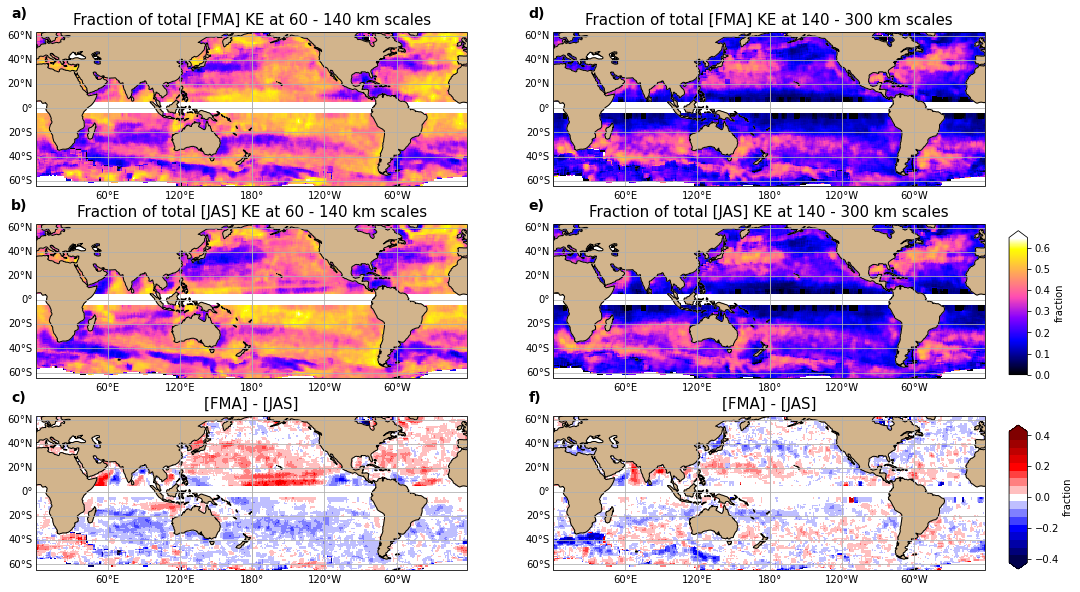

In [10]:
# seaonal changes in percent of energy in bands
land_col = '#D3D3D3'; lev2 = np.arange(0, 0.65, 0.001) # l was 0.05
dlev1 = np.arange(1, 1001, 1)
tcmap2 = plt.get_cmap('gnuplot2')
v_in = np.where((lat_bin_c > -5) & (lat_bin_c < 5))[0]

# -- unfiltered KE 
mean_raw_mask = np.nanmean(total_ke,axis=0); mean_raw_mask[:, v_in] = np.nan; 
data_coords = {'latitude': lat_bin_c, 'longitude': lon_bin_c}
test_xr = xr.DataArray(data=np.transpose(mean_raw_mask), name='total_ke', dims=['latitude', 'longitude'], coords=data_coords)

mean_mf_mask0 = meso_frac0.copy() 
mean_mfwin_mask0 = smaller_frac0_win.copy()
mean_mfsum_mask0 = smaller_frac0_sum.copy()
mean_mf_mask1 = meso_frac1.copy() 
mean_mfwin_mask1 = smaller_frac1_win.copy()
mean_mfsum_mask1 = smaller_frac1_sum.copy()
# mask equator 
mean_mf_mask0[:, v_in] = np.nan
mean_mfwin_mask0[:, v_in] = np.nan
mean_mfsum_mask0[:, v_in] = np.nan
mean_mf_mask1[:, v_in] = np.nan
mean_mfwin_mask1[:, v_in] = np.nan
mean_mfsum_mask1[:, v_in] = np.nan
# check/remove nans 
bad_check = mean_mfwin_mask1 - mean_mfsum_mask1
for i in range(np.shape(mean_mfwin_mask1)[1]):
    bad = np.where(np.abs(bad_check[:, i]) > .34)[0]
    bad_check[bad, i] = np.nan
    bad_check[bad, i] = np.nan
land_cmap2 = plt.cm.get_cmap('viridis')
land_cmap2.set_over('#D3D3D3')

data_coords = {'latitude': lat_bins[1:-1], 'longitude': lon_bins[1:-1]}
lon_xr = np.where((lon_bins[1:-1] > lon_w) & (lon_bins[1:-1] < lon_e))[0]
lat_xr = np.where((lat_bins[1:-1] > lat_s) & (lat_bins[1:-1] < lat_n))[0]
mfwin_xr = xr.DataArray(data=np.transpose(mean_mfwin_mask0), name='raw_ke', dims=['latitude', 'longitude'], coords=data_coords)
mfsum_xr = xr.DataArray(data=np.transpose(mean_mfsum_mask0), name='raw_ke', dims=['latitude', 'longitude'], coords=data_coords)
mfwinsum_xr = xr.DataArray(data=np.transpose(mean_mfwin_mask0 - mean_mfsum_mask0), name='raw_ke', dims=['latitude', 'longitude'], coords=data_coords)
mfwin1_xr = xr.DataArray(data=np.transpose(mean_mfwin_mask1), name='raw_ke', dims=['latitude', 'longitude'], coords=data_coords)
mfsum1_xr = xr.DataArray(data=np.transpose(mean_mfsum_mask1), name='raw_ke', dims=['latitude', 'longitude'], coords=data_coords)
mfwinsum1_xr = xr.DataArray(data=np.transpose(bad_check), name='raw_ke', dims=['latitude', 'longitude'], coords=data_coords)  # mean_mfwin_mask1 - mean_mfsum_mask1
# -- FIGURE -- 
f, ax = plt.subplots(3,2,figsize=(17,10), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
# -- column 0 
axpmf = mfwin_xr.isel(longitude=lon_xr, latitude=lat_xr).plot(ax=ax[0,0],transform=ccrs.PlateCarree(), \
                                                             vmin=lev2[0], vmax=lev2[-1], \
                                                             cmap=tcmap2, zorder=0, add_colorbar=False)
# ax[0,0].contour(lon_bin_c,lat_bin_c,np.transpose(mean_raw_mask),transform=ccrs.PlateCarree(), \
#                                                         levels=np.arange(0.01,1,0.04), \
#                                                         linewidths=0.4,colors='k',zorder=1)
ax[0,0].set_title(r"Fraction of total [FMA] KE at " + \
                str(np.int(np.nanmin(coarsening_factors[meso_band0_i+1])*hor_grid_spacing)) + ' - ' + \
                str(np.int(np.nanmax(coarsening_factors[meso_band0_i])*hor_grid_spacing)) + " km scales", fontsize=15)

mfsum_xr.isel(longitude=lon_xr, latitude=lat_xr).plot(ax=ax[1,0],transform=ccrs.PlateCarree(), \
                                                      vmin=lev2[0], vmax=lev2[-1], \
                                                      cmap=tcmap2, zorder=0, add_colorbar=False)
ax[1,0].set_title(r"Fraction of total [JAS] KE at " + \
                str(np.int(np.nanmin(coarsening_factors[meso_band0_i+1])*hor_grid_spacing)) + ' - ' + \
                str(np.int(np.nanmax(coarsening_factors[meso_band0_i])*hor_grid_spacing)) + " km scales", fontsize=15)
 
mfwinsum_xr.isel(longitude=lon_xr, latitude=lat_xr).plot(ax=ax[2,0],transform=ccrs.PlateCarree(), \
                                                      vmin=-0.425, vmax=0.425, \
                                                      cmap=plt.get_cmap('seismic',17), zorder=0, add_colorbar=False)
ax[2,0].set_title(r"[FMA] - [JAS]", fontsize=15)
# # -- column 1
mfwin1_xr.isel(longitude=lon_xr, latitude=lat_xr).plot(ax=ax[0,1],transform=ccrs.PlateCarree(), \
                                                      vmin=lev2[0], vmax=lev2[-1], \
                                                      cmap=tcmap2, zorder=0, add_colorbar=False)
# ax[0,1].contour(lon_bin_c,lat_bin_c,np.transpose(mean_raw_mask),transform=ccrs.PlateCarree(), \
#                                                         levels=np.arange(0.01,1,0.04), \
#                                                         linewidths=0.5,colors='w',zorder=1)
ax[0,1].set_title(r"Fraction of total [FMA] KE at " + \
                str(np.int(np.nanmin(coarsening_factors[meso_band1_i+1])*hor_grid_spacing)) + ' - ' + \
                str(np.int(np.nanmax(coarsening_factors[meso_band1_i])*hor_grid_spacing)) + " km scales", fontsize=15)

mfsum1_xr.isel(longitude=lon_xr, latitude=lat_xr).plot(ax=ax[1,1],transform=ccrs.PlateCarree(), \
                                                      vmin=lev2[0], vmax=lev2[-1], \
                                                      cmap=tcmap2, zorder=0, add_colorbar=False)
ax[1,1].set_title(r"Fraction of total [JAS] KE at " + \
                str(np.int(np.nanmin(coarsening_factors[meso_band1_i+1])*hor_grid_spacing)) + ' - ' + \
                str(np.int(np.nanmax(coarsening_factors[meso_band1_i])*hor_grid_spacing)) + " km scales", fontsize=15)
 
axpmfd = mfwinsum1_xr.isel(longitude=lon_xr, latitude=lat_xr).plot(ax=ax[2,1],transform=ccrs.PlateCarree(), \
                                                      vmin=-0.425, vmax=0.425, \
                                                      cmap=plt.get_cmap('seismic',17), zorder=0, add_colorbar=False)
ax[2,1].set_title(r"[FMA] - [JAS]", fontsize=15)

for axi in ax.flatten():
    axi.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
    axi.coastlines()
    axi.set_extent([np.nanmin(lon_bin_c[lon_xr]), np.nanmax(lon_bin_c[lon_xr]), np.nanmin(lat_bin_c[lat_xr]), np.nanmax(lat_bin_c[lat_xr])], crs=ccrs.PlateCarree())
    gl = axi.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False

cbpos = [0.92, 0.4, 0.015, 0.2]; cax = f.add_axes(cbpos);
cb = f.colorbar(axpmf, cax=cax, orientation='vertical', extend='max', label='fraction')
cbpos = [0.92, 0.13, 0.015, 0.2]; cax = f.add_axes(cbpos);
cb = f.colorbar(axpmfd, cax=cax, orientation='vertical', extend='both', label='fraction')
ax[0,0].text(-200, 75, 'a)', fontweight='bold', fontsize=14); ax[1,0].text(-200, 75, 'b)', fontweight='bold', fontsize=14);
ax[2,0].text(-200, 75, 'c)', fontweight='bold', fontsize=14); ax[0,1].text(-200, 75, 'd)', fontweight='bold', fontsize=14);
ax[1,1].text(-200, 75, 'e)', fontweight='bold', fontsize=14); ax[2,1].text(-200, 75, 'f)', fontweight='bold', fontsize=14);
plt.show()
f.savefig('/Users/jakesteinberg/Desktop/cpt_manuscript_figures/r3/figures/j2_along_track_gridding_seasonal_percent_ke.jpg', dpi=550)

In [12]:
# ARGO MLD/APE 
# f_argo_pe = '/Users/jakesteinberg/Documents/CPT/Argo/Argo_PE_APEConversion6.nc'
# argo_pe = xr.open_dataset(f_argo_pe)
# pe_lon = argo_pe.lon.longitude.data
# pe_lat = argo_pe.lat.latitude.data
# pe = argo_pe['pe'].data
ape_rate = pe_rate.copy()
max_ape_rate = np.nanmax(ape_rate,axis=0) - np.nanmin(ape_rate,axis=0)

# from altimetry_tools import Filter
# pe_mean = np.nanmean(ape_rate, axis=0)
# pe_smooth = np.nan * np.ones(np.shape(pe_mean))
# max_ape_smooth = np.nan * np.ones(np.shape(pe_mean))
# for i in range(np.shape(ape_rate)[1]):
#     # ff1 = Filter('Gaussian', [pe_mean[i,:][None,:]], 1, 20, plot_filter=0) 
#     # pe_smooth[i,:] = ff1[0]
#     ff1 = Filter('Gaussian', [max_ape_rate[i,:][None,:]], 1, 20, plot_filter=0) 
#     max_ape_smooth[i,:] = ff1[0]
    
# for j in range(np.shape(ape_rate)[2]):
#     # ff1 = Filter('Gaussian', [pe_mean[:,j][None,:]], 1, 20, plot_filter=0) 
#     # pe_smooth[:,j] = ff1[0]
#     ff1 = Filter('Gaussian', [max_ape_rate[:,j][None,:]], 1, 20, plot_filter=0) 
#     max_ape_smooth[:,j] = ff1[0]

# month when PE is a maximum 
pe_max_month = np.nan*np.ones(np.shape(ape_rate[0]))
for i in range(np.shape(ape_rate)[1]):
    for j in range(np.shape(ape_rate)[2]):
        
        # -- if using pe not pe_rate --
        # this_pe = pe[:,i,j]
        # pet = -1*(this_pe - np.nanmean(this_pe))
        # if (np.sum(np.abs(this_pe)) > 0): # & (len(indi) > 0):  
        #     top_10pct = np.where(pet >= np.nanmax(pet)*.9)[0]
        #     indi = top_10pct[0]  
        #     pe_max_month[i,j] = indi + 1
        # -- if using pe_rate --
        this_pe = ape_rate[:,i,j]
        if (np.sum(np.abs(this_pe)) > 0):
            top_10pct = np.where(this_pe >= np.nanmax(this_pe)*.9)[0]
            indi = top_10pct[0]
            pe_max_month[i,j] = indi + 1
            

In [13]:
# -- peak eke month -- 
# scales to map
scale1 = np.where(coarsening_factors == 3)[0]
scale2 = np.where(coarsening_factors == 15)[0]
pct_diff_cutoff = 0.25
# find month that has most eke at each scale 
max_month_1 = np.nan * np.ones(np.shape(eke[0, :, :, 0]))
max_month_2 = np.nan * np.ones(np.shape(eke[0, :, :, 0]))
for i in range(np.shape(eke)[1]):
    for j in range(np.shape(eke)[2]):
        # -- scale1 (smaller)
        if (~np.isnan(np.nanmax(eke[:, i, j, scale1]))) & \
        (np.abs(np.nanmax(eke[:, i, j, scale1]) - np.nanmin(eke[:, i, j, scale1]))/np.nanmean(eke[:, i, j, scale1]) > pct_diff_cutoff):
            this_ij = np.where(eke[:, i, j, scale1] == np.nanmax(eke[:, i, j, scale1]))[0]
            if len(this_ij) > 1:
                max_month_1[i, j] = np.nanmean(this_ij) + 1
            else:
                max_month_1[i, j] = this_ij + 1
        # -- scale2 (larger) 
        if (~np.isnan(np.nanmax(eke[:, i, j, scale2]))) & \
        (np.abs(np.nanmax(eke[:, i, j, scale2]) - np.nanmin(eke[:, i, j, scale2]))/np.nanmean(eke[:, i, j, scale2]) > pct_diff_cutoff):
            test = eke[:, i, j, scale2] - eke[:, i, j, scale1]  # difference between scales 
            this_ij = np.where(test == np.nanmax(test))[0]
            if len(this_ij) > 1:
                max_month_2[i, j] = np.nanmean(this_ij) + 1
            else:
                max_month_2[i, j] = this_ij + 1

# put output in xarray
data_coords = {'latitude': lat_bin_c, 'longitude': lon_bin_c}
lon_xr = np.where((lon_bins[1:-1] > lon_w) & (lon_bins[1:-1] < lon_e))[0]
lat_xr_s = np.where(((lat_bins[1:-1] > lat_s) & (lat_bins[1:-1] < -5)))[0]
lat_xr_n = np.where(((lat_bins[1:-1] > 5) & (lat_bins[1:-1] < lat_n)))[0]
mm1_xr = xr.DataArray(data=np.transpose(max_month_1), name='less_than_80', dims=['latitude', 'longitude'], coords=data_coords)
mm2_xr = xr.DataArray(data=np.transpose(max_month_2), name='less_than_80', dims=['latitude', 'longitude'], coords=data_coords)
eqq = np.where((lat_bins[1:-1] > -2) & (lat_bins[1:-1] < 2))[0]

In [14]:
# where is seasonality less than 20% of mean 
pct_diff_cutoff_t = 0.25
scale_t = np.where(coarsening_factors == 3)[0]
test = np.nan * np.ones((np.shape(eke)[1], np.shape(eke)[2]))
for i in tqdm(range(np.shape(eke)[1])):
    for j in range(np.shape(eke)[2]):
        if np.sum(np.isnan(eke[:, i, j, scale_t])) < 3:
            test[i,j] = 0
        if (np.abs(np.nanmax(eke[:, i, j, scale_t]) - np.nanmin(eke[:, i, j, scale_t]))/\
                np.nanmean(eke[:, i, j, scale_t]) < pct_diff_cutoff_t):
            test[i,j] = 1

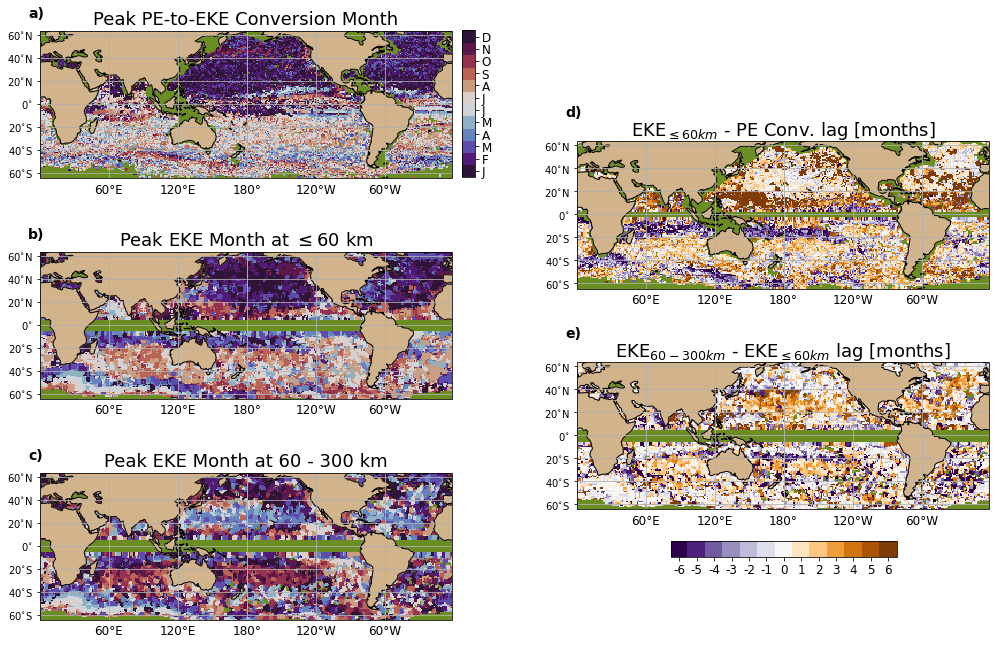

In [22]:
# ------------------------
# -- PLOT --        
# ------------------------
fig = plt.figure(figsize=(17, 11))
gs = GridSpec(11, 9, figure=fig)
ax0 = fig.add_subplot(gs[0:3, 0:4], projection=ccrs.PlateCarree(central_longitude=180))
ax1 = fig.add_subplot(gs[4:7, 0:4], projection=ccrs.PlateCarree(central_longitude=180))
ax2 = fig.add_subplot(gs[8:, 0:4], projection=ccrs.PlateCarree(central_longitude=180))
ax35 = fig.add_subplot(gs[2:5, 5:], projection=ccrs.PlateCarree(central_longitude=180))
ax3 = fig.add_subplot(gs[6:9, 5:], projection=ccrs.PlateCarree(central_longitude=180))
# aa1 = f.add_subplot(gs[6, 0]) # aa2 = f.add_subplot(gs[6, 1]) # aa3 = f.add_subplot(gs[6, 2])

# - 0 - 
data_coords_pe = {'latitude': pe_lat, 'longitude': pe_lon}
pe_mmax_xr = xr.DataArray(data=pe_max_month,  dims=['latitude', 'longitude'], coords=data_coords_pe) 
axp1 = pe_mmax_xr.plot(ax=ax0,transform=ccrs.PlateCarree(), vmin=0.5, vmax=12.5, \
                cmap=plt.get_cmap('twilight_shifted',12), zorder=0, add_colorbar=False)
ax0.set_title('Peak PE-to-EKE Conversion Month', fontsize=18)

# - 1 - 
axp0 = mm1_xr.isel(longitude=lon_xr, latitude=lat_xr_n).plot(ax=ax1,transform=ccrs.PlateCarree(), vmin=0.5, vmax=12.5, \
                                                      cmap=plt.get_cmap('twilight_shifted',12), zorder=0, add_colorbar=False, extend="neither")
axp0 = mm1_xr.isel(longitude=lon_xr, latitude=lat_xr_s).plot(ax=ax1,transform=ccrs.PlateCarree(), vmin=0.5, vmax=12.5, \
                                                      cmap=plt.get_cmap('twilight_shifted',12), zorder=0, add_colorbar=False, extend="neither")
ax1.set_title('Peak EKE Month at $\leq$' + str(np.int(coarsening_factors[scale1][0]*hor_grid_spacing)) + ' km', fontsize=18)
# dr = ax1.contour(lon_bin_c, lat_bin_c, def_rad, levels=[25, 50, 75, 100], colors='w', linewidths=1, zorder=2, transform=ccrs.PlateCarree())
# ax1.clabel(dr, fontsize=9, inline=1, fmt = '%1.1f')

# - 2-  
axp = mm2_xr.isel(longitude=lon_xr, latitude=lat_xr_n).plot(ax=ax2,transform=ccrs.PlateCarree(), vmin=0.5, vmax=12.5, \
                                                      cmap=plt.get_cmap('twilight_shifted',12), zorder=0, add_colorbar=False)
axp = mm2_xr.isel(longitude=lon_xr, latitude=lat_xr_s).plot(ax=ax2,transform=ccrs.PlateCarree(), vmin=0.5, vmax=12.5, \
                                                      cmap=plt.get_cmap('twilight_shifted',12), zorder=0, add_colorbar=False)
# ax2.contour(lon_bin_c, lat_bin_c, def_rad, levels=[25, 50, 75, 100], colors='w', linewidths=1, zorder=2, transform=ccrs.PlateCarree())
ax2.set_title('Peak EKE Month at ' + str(np.int(coarsening_factors[scale1][0]*hor_grid_spacing)) + ' - ' + \
              str(np.int(coarsening_factors[scale2][0]*hor_grid_spacing)) + ' km', fontsize=18)

# check that 
mo_lag = max_month_2 - max_month_1
for i in range(np.shape(max_month_2)[0]):
    pos_lag_easy = np.where(max_month_2[i, :] > max_month_1[i, :])[0]
    lag_hard1 = np.where( (max_month_1[i, :] >= 9.0) & (max_month_2[i, :] <= 6.0) )[0]
    lag_hard2 = np.where( (max_month_2[i, :] >= 9.0) & (max_month_1[i, :] <= 6.0) )[0]
    mo_lag[i, lag_hard1] = mo_lag[i, lag_hard1] + 12
    mo_lag[i, lag_hard2] = mo_lag[i, lag_hard2] - 12
mo_lag_ref = mo_lag.copy()
# - 3 - 
# mo_lag[mo_lag < 0] = np.nan
# mo_lag[mo_lag > 5] = np.nan
cmap_lag = plt.get_cmap('PuOr_r',13)
lag_tp = [-6.5,6.5]
mol_xr = xr.DataArray(data=np.transpose(mo_lag), name='lag', dims=['latitude', 'longitude'], coords=data_coords) 
axp2 = mol_xr.isel(longitude=lon_xr, latitude=lat_xr_n).plot(ax=ax3,transform=ccrs.PlateCarree(), \
                                                             vmin=lag_tp[0], vmax=lag_tp[1], \
                                                             cmap=cmap_lag, zorder=0, add_colorbar=False)
axp2 = mol_xr.isel(longitude=lon_xr, latitude=lat_xr_s).plot(ax=ax3,transform=ccrs.PlateCarree(), \
                                                             vmin=lag_tp[0], vmax=lag_tp[1], \
                                                             cmap=cmap_lag, zorder=0, add_colorbar=False)
ax3.set_title('EKE$_{60-300 km}$ - EKE$_{\leq 60 km}$ lag [months]', fontsize=18)

# - 4 - 
# - EKE PE LAG 
# - lag between month of max pe and month of max eke at the smallest scale
# r1 = np.where(pe_lon > 360)[0]
# pe_max_month_align = np.concatenate((pe_max_month[:,r1], pe_max_month[:,0:r1[0]]),axis=1)
# [ii, ai, bi] = np.intersect1d(pe_lat,lat_bin_c[1:-1],return_indices=True)
# pe_eke_lag = np.transpose(max_month_1)[bi,:] - pe_max_month_align[ai,:]

[ii, ai, bi0] = np.intersect1d(pe_lat,lat_bin_c[1:-1],return_indices=True)
pe_max_month_align = pe_max_month[ai,:]
[ii, ai, bi] = np.intersect1d(pe_lon,lon_bin_c,return_indices=True)
pe_max_month_align = pe_max_month_align[:,ai]
pe_eke_lag = np.transpose(max_month_1)[bi0,:] - pe_max_month_align

# check for jump at turn of year
for i in range(np.shape(pe_eke_lag)[0]):
    cc = np.where(pe_eke_lag[i,:] <= -9)[0]
    pe_eke_lag[i,cc] = pe_eke_lag[i,cc] + 12

# pe_eke_lag[pe_eke_lag < 0] = np.nan
# pe_eke_lag[pe_eke_lag > 5] = np.nan
data_coords_pe = {'latitude': lat_bin_c[bi0], 'longitude': lon_bin_c}
pe_mmax_xr = xr.DataArray(data=pe_eke_lag,  dims=['latitude', 'longitude'], coords=data_coords_pe) 
pel = pe_mmax_xr.plot(ax=ax35,transform=ccrs.PlateCarree(), vmin=lag_tp[0], vmax=lag_tp[1], \
                cmap=cmap_lag, zorder=1, add_colorbar=False) # vmin/vmax = 0/5, 5 discrete colors
ax35.set_title('EKE$_{\leq 60 km}$ - PE Conv. lag [months]', fontsize=18)

# -- colorbars 
cbpos0 = [0.47, 0.13, 0.01, 0.185] # [0.92, 0.525, 0.02, 0.14]
cbpos01 = [0.47, 0.41, 0.01, 0.185]
cbpos02 = [0.47, 0.69, 0.01, 0.185]
# lags
cbpos25 = [0.64, 0.21, 0.185, 0.02] # was 2
# cbpos25 = [0.64, 0.81, 0.185, 0.02] 

# cax0 = fig.add_axes(cbpos0)
# cax01 = fig.add_axes(cbpos01)
cax02 = fig.add_axes(cbpos02)
# cax2 = fig.add_axes(cbpos2)
cax25 = fig.add_axes(cbpos25)

# cb0 = fig.colorbar(axp0, cax=cax0, orientation='vertical', extend='neither', ticks=np.arange(1,13))
# cb0.ax.set_yticklabels([month_labels[0],month_labels[1],month_labels[2],month_labels[3],month_labels[4],month_labels[5],\
#                        month_labels[6],month_labels[7],month_labels[8],month_labels[9],month_labels[10],month_labels[11]], fontsize=12)
# cb01 = fig.colorbar(axp, cax=cax01, orientation='vertical', extend='neither', ticks=np.arange(1,13))
# cb01.ax.set_yticklabels([month_labels[0],month_labels[1],month_labels[2],month_labels[3],month_labels[4],month_labels[5],\
#                        month_labels[6],month_labels[7],month_labels[8],month_labels[9],month_labels[10],month_labels[11]], fontsize=12)
cb02 = fig.colorbar(axp1, cax=cax02, orientation='vertical', extend='neither', ticks=np.arange(1,13))
cb02.ax.set_yticklabels([month_labels[0],month_labels[1],month_labels[2],month_labels[3],month_labels[4],month_labels[5],\
                       month_labels[6],month_labels[7],month_labels[8],month_labels[9],month_labels[10],month_labels[11]], fontsize=12)
# cb2 = fig.colorbar(axp2, cax=cax2, orientation='horizontal', extend='both', ticks=np.arange(-6,7))
# cb2.ax.set_xticklabels(np.arange(-6,7), fontsize=12)
cb25 = fig.colorbar(pel, cax=cax25, orientation='horizontal', ticks=np.arange(-6,7)) # (0,6)+0.5
cb25.ax.set_xticklabels(np.arange(-6,7), fontsize=12) # (0,6)

ax0.text(-190, 75, 'a)', fontweight='bold', fontsize=14)
ax1.text(-190, 75, 'b)', fontweight='bold', fontsize=14)
ax2.text(-190, 75, 'c)', fontweight='bold', fontsize=14)
ax35.text(-190, 85, 'd)', fontweight='bold', fontsize=14)
ax3.text(-190, 85, 'e)', fontweight='bold', fontsize=14)

# -- inset subplots with seasonal cycles 
# colors2 = ['r', '#FFD700', '#32CD32', '#FF00FF']  # '#00FF00'
# for i in [1,2,3]:  # range(len(order[0:5])):
#     this_lon0 = location[i, 0] - 1
#     this_lon1 = location[i, 1] + 1
#     this_lat0 = location[i, 2] - 1 
#     this_lat1 = location[i, 3] + 1
#     for axi in [ax1, ax2, ax3]:
#         axi.fill_between([this_lon0, this_lon1], [this_lat0, this_lat0], [this_lat1, this_lat1], color=colors2[i], transform=ccrs.PlateCarree())

# to_show = np.where((coarsening_factors == 3) | (coarsening_factors == 7) | (coarsening_factors == 15))[0]
# ibc = '#525252'
# aa1.set_facecolor(ibc)
# aa2.set_facecolor(ibc)
# aa3.set_facecolor(ibc)
# i = 1
# for ai in [aa1, aa2, aa3]:
#     ai.plot(frac_year, np.nanmean(eke[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[0]], axis=tuple(range(1, 3)))/\
#                  np.nanmean(eke[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[0]]), \
#                  color=colors2[i], label='l=' + str(coarsening_factors[to_show[0]]*hor_grid_spacing) + 'km', linestyle='-.', linewidth=2.25)
#     ai.plot(frac_year, np.nanmean(eke[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[1]], axis=tuple(range(1, 3)))/\
#                  np.nanmean(eke[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[1]]), \
#                  color=colors2[i], label='l=' + str(coarsening_factors[to_show[1]]*hor_grid_spacing) + 'km', linestyle='--', linewidth=2.25)
#     ai.plot(frac_year, np.nanmean(eke[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[2]], axis=tuple(range(1, 3)))/\
#                  np.nanmean(eke[:, in_lon[i]][:, :, in_lat[i]][:,:,:,to_show[2]]), \
#                  color=colors2[i], label='l=' + str(coarsening_factors[to_show[2]]*hor_grid_spacing) + 'km', linewidth=2.25)
#     ai.text(frac_year[0], 0.65, 'mean KE [m$^2$s$^{-1}$] = ' + \
#             str(np.round(np.nanmean(total_ke[:, in_lon[i]][:, :, in_lat[i]]), 5)), fontweight='bold', fontsize=12, color='w')
#     ai.set_xticks(frac_year)
#     ai.set_xticklabels(month_labels)
#     ai.set_ylim([0.6, 1.5])
#     ai.text(frac_year[0], 1.39, 'Loc: ' + str(i), fontweight='bold', fontsize=12, color='w')
#     ai.grid(color='#767676')
#     i = i + 1
# handles, labels = aa1.get_legend_handles_labels()
# ll = aa1.legend(handles, labels, fontsize=11, facecolor='#7d7d7d')
# for text in ll.get_texts():
#     text.set_color("w")
# aa3.set(yticklabels=[])
# aa2.set(yticklabels=[])

# -- formatting 
for axi in ax0, ax1, ax2, ax35, ax3:
    axi.set_yticks([-60, -40, -20, 0, 20, 40, 60])
    axi.set_yticklabels(['60$^{\circ}$S','40$^{\circ}$S','20$^{\circ}$S','0$^{\circ}$','20$^{\circ}$N','40$^{\circ}$N','60$^{\circ}$N'])
    axi.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
    axi.coastlines()
    axi.set_extent([np.nanmin(lon_bin_c[lon_xr]), np.nanmax(lon_bin_c[lon_xr]), \
                np.nanmin(lat_bin_c[lat_xr_s]), np.nanmax(lat_bin_c[lat_xr_n])], crs=ccrs.PlateCarree())
    gl = axi.gridlines(draw_labels=True)
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylabels_left = False
    axi.set_ylabel('')

outt = '#6B8E23'; ax0.set_facecolor(outt); ax1.set_facecolor(outt); ax2.set_facecolor(outt);
outt2 = '#6B8E23'; ax3.set_facecolor(outt2); ax35.set_facecolor(outt2);
fig.savefig('/Users/jakesteinberg/Desktop/cpt_manuscript_figures/r3/figures/lag_figure_cutoff.png', dpi=200, pad_inches=0)

In [167]:
np.shape(mo_lag)

(360, 140)

In [99]:
test1 = pe_max_month_align[ai,:] 
test2 = np.transpose(max_month_1)[bi,:]

In [100]:
la1 = -40
la2 = -50
lo1 = 110
lo2 = 120
print(test1[np.where((lat_bin_c[bi] > la2) & (lat_bin_c[bi] < la1))][:, np.where((lon_bin_c > lo1) & (lon_bin_c < lo2))])
print(test2[np.where((lat_bin_c[bi] > la2) & (lat_bin_c[bi] < la1))][:, np.where((lon_bin_c > lo1) & (lon_bin_c < lo2))])
print(test2[np.where((lat_bin_c[bi] > la2) & (lat_bin_c[bi] < la1))][:, np.where((lon_bin_c > lo1) & (lon_bin_c < lo2))] - \
      test1[np.where((lat_bin_c[bi] > la2) & (lat_bin_c[bi] < la1))][:, np.where((lon_bin_c > lo1) & (lon_bin_c < lo2))])

[[[ 7.  8.  9.  9.  9. 10. 10. 10.  3.  9.]]

 [[10.  8.  9.  9.  9.  9.  9. 10. 10. 10.]]

 [[ 9. 10.  9. 10. 10. 10. 10. 10. 10.  3.]]

 [[ 8.  8.  4. 11.  1. 11. 11. 10. 11. 10.]]

 [[ 7. 11.  3. 11.  1.  1.  2. 10.  3.  1.]]

 [[ 3. 10.  3.  2.  4.  3.  2.  3.  3.  2.]]

 [[ 4.  4.  4. 10.  4.  9.  5.  4.  5.  3.]]

 [[10.  6.  4.  9.  9.  3.  3.  4.  4.  4.]]

 [[ 7.  7.  7.  9.  9.  5.  9.  4.  4.  4.]]

 [[ 9.  7.  8.  6.  8.  8.  7.  7.  6.  6.]]]
[[[3. 2. 4. 3. 3. 3. 3. 3. 3. 3.]]

 [[3. 2. 4. 2. 3. 3. 3. 3. 3. 3.]]

 [[2. 2. 4. 2. 2. 3. 3. 3. 3. 3.]]

 [[8. 8. 2. 2. 2. 2. 1. 3. 3. 8.]]

 [[8. 8. 8. 2. 2. 2. 2. 9. 4. 8.]]

 [[8. 8. 8. 8. 8. 9. 9. 9. 8. 8.]]

 [[8. 8. 8. 8. 9. 3. 3. 3. 3. 4.]]

 [[9. 7. 4. 9. 9. 3. 3. 3. 3. 4.]]

 [[9. 9. 4. 9. 9. 3. 3. 3. 3. 9.]]

 [[9. 9. 7. 7. 7. 3. 3. 3. 3. 9.]]]
[[[ -4.  -6.  -5.  -6.  -6.  -7.  -7.  -7.   0.  -6.]]

 [[ -7.  -6.  -5.  -7.  -6.  -6.  -6.  -7.  -7.  -7.]]

 [[ -7.  -8.  -5.  -8.  -8.  -7.  -7.  -7.  -7.   0.]]

 [[  0.   0.

In [40]:
meso_band_n_i = np.where((coarsening_factors <= 7) & (coarsening_factors >= 4))[0] # was (7,4) 80-160 km 
loc_var_bm = np.nan * np.ones((len(frac_year), len(lon_bin_c), len(lat_bin_c), len(coarsening_factors)))
loc_tot_var_bm = np.nan * np.ones((len(frac_year), len(lon_bin_c), len(lat_bin_c)))
smaller_frac0_bm = np.nan * np.ones((len(frac_year), len(lon_bin_c), len(lat_bin_c)))
for i in tqdm(range(1, len(lon_bin_c) - 1)):
    for j in range(1, len(lat_bin_c) - 1):
        this_lon = lon_bin_c[i]
        this_lat = lat_bin_c[j]      
        this_lon0 = this_lon - 0.5  # lon_win/2
        this_lon1 = this_lon + 0.5  # lon_win/2
        this_lat0 = this_lat - 0.5  # lat_win/2
        this_lat1 = this_lat + 0.5  # lat_win/2   
        ll = np.where((lat_bin_c > (this_lat0 - 0)) & (lat_bin_c < (this_lat1 + 0)))[0]
        kk = np.where((lon_bin_c > (this_lon0 - 0)) & (lon_bin_c < (this_lon1 + 0)))[0]
        
        for m in range(len(frac_year)):
            loc_var_bm[m, i, j, :] = filtered_ke[m][kk, :, :][:, ll, :]
            loc_tot_var_bm[m, i, j] = total_ke[m][kk, :][:, ll]
            # 'spectra' as a function of filter scale 
            this_spec_bm = loc_var_bm[m, i, j, :][None, :]
            # area under the curve 
            sample_band_bm = (this_spec_bm[0, 1:] - this_spec_bm[0, 0:-1])
            # sum band passed variance estimate 
            # smaller_frac0_bm[m,i,j] = np.sum(sample_band_bm[meso_band0_i])/loc_tot_var_bm[m,i,j]
            # - smallest scale up to 120 km
            smaller_frac0_bm[m,i,j] = np.sum(sample_band_bm[meso_band_n_i[0]:])/loc_tot_var_bm[m,i,j]
        
        
mean_mf_bm_mask0 = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_mf_bm_mask0_i = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
for i in tqdm(range(1, len(lon_bin_c) - 1)):
    for j in range(1, len(lat_bin_c) - 1):
        mean_mf_bm_mask0[i,j] = np.nanmax(smaller_frac0_bm[:,i,j]) - np.nanmin(smaller_frac0_bm[:,i,j])
        if (np.sum(np.isnan(smaller_frac0_bm[:,i,j])) < 4) & (np.nanmean(smaller_frac0_bm[:,i,j]) > 0):
            mean_mf_bm_mask0_i[i,j] = np.where(smaller_frac0_bm[:,i,j] == np.nanmax(smaller_frac0_bm[:,i,j]))[0]
data_coords = {'latitude': lat_bin_c, 'longitude': lon_bin_c}
eq_lat = np.where((lat_bin_c < 7) & (lat_bin_c > -7))[0]
mean_mf_bm_mask0[:, eq_lat] = np.nan
mfmaxmin_xr = xr.DataArray(data=np.transpose(mean_mf_bm_mask0), \
                           name='small_eke_diff', dims=['latitude', 'longitude'], coords=data_coords)
mfmaxmonth_xr = xr.DataArray(data=np.transpose(mean_mf_bm_mask0_i), \
                           name='small_eke_max_month', dims=['latitude', 'longitude'], coords=data_coords)

In [61]:
np.nanmean(mean_mf_bm_mask0[np.where(mean_mf_bm_mask0 < 2)[0],np.where(mean_mf_bm_mask0 < 2)[1]])

0.1307305162146915

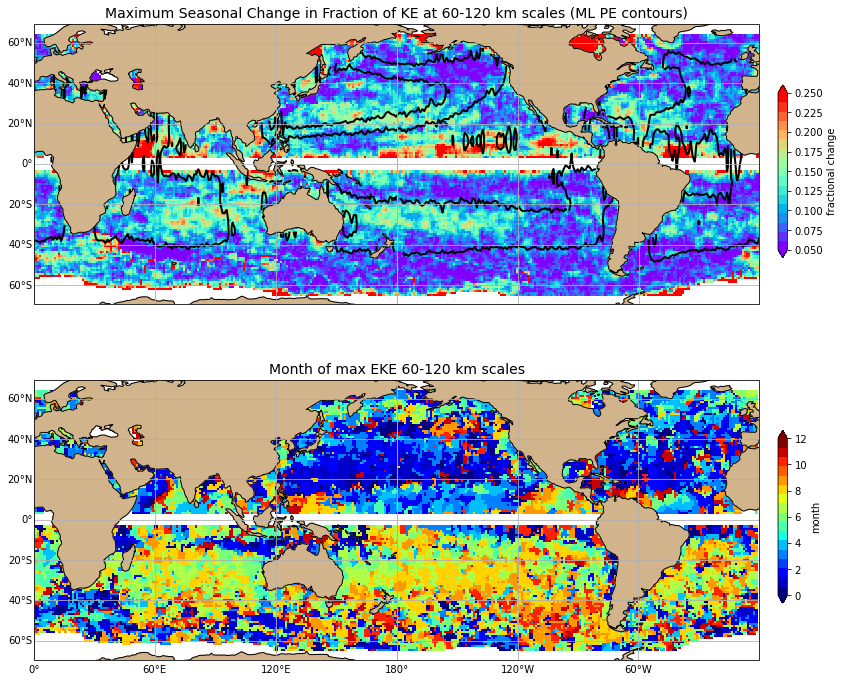

In [24]:
# ALIGNMENT WITH ARGO 
lon_xr = np.where((lon_bins[1:-1] > lon_w) & (lon_bins[1:-1] < lon_e))[0]
lat_xr = np.where((lat_bins[1:-1] > lat_s) & (lat_bins[1:-1] < lat_n))[0]
cmap_sea = plt.get_cmap('plasma',13)
# mfwinsum_xr
f, (ax,ax2) = plt.subplots(2,1,figsize=(13,12), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
axp=mfmaxmin_xr.isel(longitude=lon_xr, latitude=lat_xr).plot(ax=ax,transform=ccrs.PlateCarree(), \
                                                      vmin=0.05, vmax=0.25, \
                                                      cmap=plt.get_cmap('rainbow',17), zorder=0, add_colorbar=False) # -0.425

# -- mld difference * ml density differnce (sylvia's method)
ax.contour(pe_lon,pe_lat,pe_smooth,levels=[7500, 15000],\
            linewidths=2,zorder=2,transform=ccrs.PlateCarree(),colors='k') # levels=[100,200] colors='r',linewidths=1.5,

# r1 = np.where(mld_lon < 0)[0]
# mld_test = np.concatenate((mld_energy_smooth[:,r1[-1]+1:], mld_energy_smooth[:,r1]),axis=1)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines()
cbpos = [0.92, 0.6, 0.01, 0.2]
cax = f.add_axes(cbpos)
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both', label='fractional change')
ax.set_ylim([np.nanmin(lat_bin_c), np.nanmax(lat_bin_c)])
ax.set_title('Maximum Seasonal Change in Fraction of KE at 60-120 km scales (ML PE contours)', fontsize=14)
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.xlabels_bottom = False

# Figure 2 
axp=mfmaxmonth_xr.isel(longitude=lon_xr, latitude=lat_xr).plot(ax=ax2,transform=ccrs.PlateCarree(), \
                                                      vmin=0, vmax=12, \
                                                      cmap=plt.get_cmap('jet',17), zorder=0, add_colorbar=False) # -0.425
ax2.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax2.coastlines()
cbpos = [0.92, 0.2, 0.01, 0.2]
cax = f.add_axes(cbpos)
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both', label='month')
ax2.set_ylim([np.nanmin(lat_bin_c), np.nanmax(lat_bin_c)])
ax2.set_title('Month of max EKE 60-120 km scales', fontsize=14)
gl = ax2.gridlines(draw_labels=True)
gl.xlabels_top = False

# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_08_06/small_scale_eke_2.jpg', dpi=500)

Text(0.5, 1.0, 'Month of max EKE 60-120 km scales')

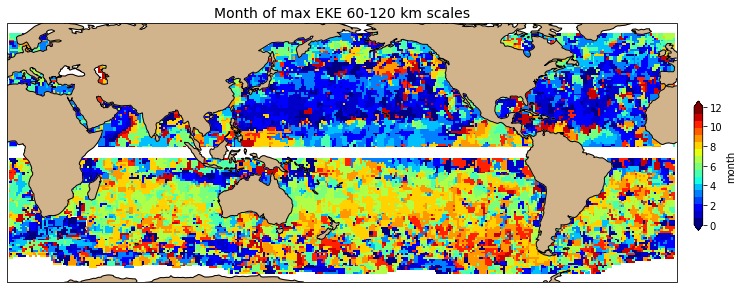

In [227]:
# month of small eke max  
cmap_sea = plt.get_cmap('plasma',13)
# mfwinsum_xr
f, ax = plt.subplots(1,1,figsize=(12,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
axp=mfmaxmonth_xr.isel(longitude=lon_xr, latitude=lat_xr).plot(ax=ax,transform=ccrs.PlateCarree(), \
                                                      vmin=0, vmax=12, \
                                                      cmap=plt.get_cmap('jet',17), zorder=0, add_colorbar=False) # -0.425
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines()
cbpos = [0.92, 0.322, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(axp, cax=cax, orientation='vertical', extend='both', label='month')
ax.set_ylim([np.nanmin(lat_bin_c), np.nanmax(lat_bin_c)])
ax.set_title('Month of max EKE 60-120 km scales', fontsize=14)
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_08_06/small_scale_eke_2.jpg', dpi=500)

In [85]:
np.shape(mean_mf_bm_mask0)

(360, 140)

In [86]:
from altimetry_tools import Filter
eke_small_smooth = np.nan * np.ones(np.shape(mean_mf_bm_mask0))
for i in range(np.shape(mean_mf_bm_mask0)[0]):
    ff1 = Filter('Gaussian', [mean_mf_bm_mask0[i,:][None,:]], 1, 2, plot_filter=0) 
    eke_small_smooth[i,:] = ff1[0]
for j in range(np.shape(mean_mf_bm_mask0)[1]):
    ff1 = Filter('Gaussian', [mean_mf_bm_mask0[:,j][None,:]], 1, 2, plot_filter=0) 
    eke_small_smooth[:,j] = ff1[0]

Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>

In [87]:
# -- need to shift/re-set longitudes 
[ii, ai, bi] = np.intersect1d(pe_lat,lat_bin_c[1:-1],return_indices=True)
mean_pe = max_ape_rate.copy() # pe_smooth
# -- RG
# r1 = np.where(pe_lon > 360)[0]
# pe_ra = np.concatenate((mean_pe[:,r1], mean_pe[:,0:r1[0]]),axis=1)
# -- MIMOC 
# [iis, ais, bis] = np.intersect1d(pe_lon,lon_bin_c,return_indices=True)
# pe_ra = mean_pe[:,ais]

In [64]:
np.shape(win_m_sum_80_160[bi,:])

(134, 360)

In [98]:
# PE-to-EKE Conversion and EKE_60-140 overlap 
pe_overlap_contours = [1*np.nanmean(pe_ra), 1] # [0.00001,0.03]
small_scale_eke_crit = 0.133 # np.nanmean(win_m_sum_80_160)
# win_m_sum_80_160 = np.transpose(mean_mfwin_mask0[:,0:-1] - mean_mfsum_mask0[:,0:-1])
win_m_sum_80_160 = np.transpose(eke_small_smooth) # np.transpose(mean_mf_bm_mask0)
# overlap_x,overlap_y = np.where((pe_ra[ai,:]>np.nanmean(pe_ra)) & (np.abs(win_m_sum_80_160[bi,:]) > 0.11))
overlap_x,overlap_y = np.where((pe_ra[ai,:]>pe_overlap_contours[0]) & \
                               (pe_ra[ai,:]<pe_overlap_contours[1]) & \
                               (np.abs(win_m_sum_80_160[bi,:]) > small_scale_eke_crit))
test_m = np.zeros(np.shape(win_m_sum_80_160[bi,:]))
for i in range(len(overlap_x)):
    test_m[overlap_x[i],overlap_y[i]] = 1

In [99]:
# PE-to-EKE Conversion and EKE lag  
mo_lag_cp = np.transpose(mo_lag.copy())
mo_lag_cp[(mo_lag_cp >= 1) & (mo_lag_cp < 5)] = 5
overlap_x2,overlap_y2 = np.where((pe_ra[ai,:]>pe_overlap_contours[0]) & \
                               (pe_ra[ai,:]<pe_overlap_contours[1]) & (mo_lag_cp[bi,:] > 1))
test_m2 = np.zeros(np.shape(mo_lag_cp[bi,:]))
for i in range(len(overlap_x2)):
    test_m2[overlap_x2[i],overlap_y2[i]] = 1

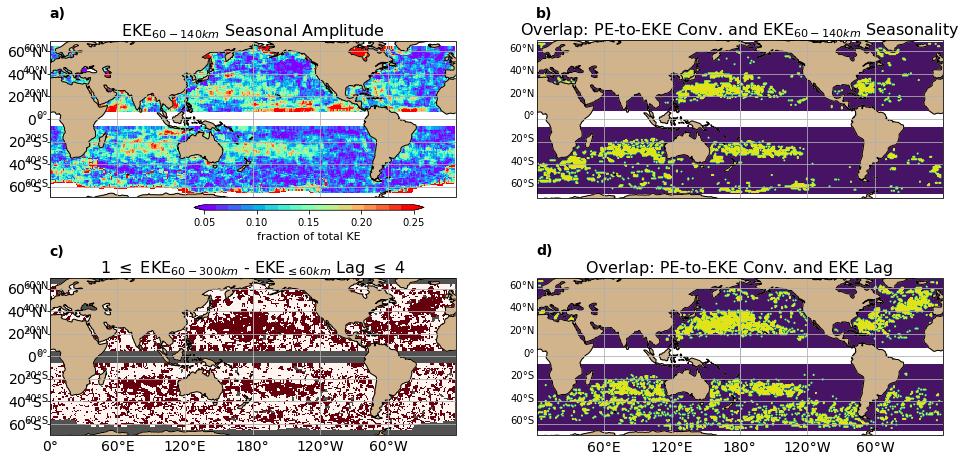

In [101]:
f, ax = plt.subplots(2,2,figsize=(16,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
# EKE & PE 
lon_xr = np.where((lon_bins[1:-1] > lon_w) & (lon_bins[1:-1] < lon_e))[0]
lat_xr = np.where((lat_bins[1:-1] > lat_s) & (lat_bins[1:-1] < lat_n))[0]
cmap_sea = plt.get_cmap('plasma',13)
axp=mfmaxmin_xr.isel(longitude=lon_xr, latitude=lat_xr).plot(ax=ax[0,0],transform=ccrs.PlateCarree(), \
                                                      vmin=0.05, vmax=0.25, \
                                                      cmap=plt.get_cmap('rainbow',17), \
                                                      zorder=0, add_colorbar=False) # 0.05, 0.25
# ax0.contour(pe_lon,pe_lat,max_ape_smooth,levels=[pe_overlap_contours[0],pe_overlap_contours[1]], \
#             linewidths=3,zorder=2,transform=ccrs.PlateCarree(),colors='k') 
# ax0.contour(pe_lon,pe_lat,pe_smooth,levels=[7500, 15000],linewidths=2,zorder=2,transform=ccrs.PlateCarree(),colors='k') 
ax[0,0].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax[0,0].coastlines()
cbpos = [0.25, 0.55, 0.2, 0.01]
cax = f.add_axes(cbpos)
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')
cb.set_label(label='fraction of total KE', fontsize=11)
ax[0,0].set_ylim([np.nanmin(lat_bin_c), np.nanmax(lat_bin_c)])
ax[0,0].set_title('EKE$_{60-140 km}$ Seasonal Amplitude', fontsize=16)
gl = ax[0,0].gridlines(draw_labels=True)
gl.xlabels_top = False
gl.xlabels_bottom = False

# OVERLAP 
eq_lat = np.where((lat_bin_c[bi] < 7) & (lat_bin_c[bi] > -7))[0]
test_m[eq_lat,:] = np.nan
ax[0,1].contourf(lon_bin_c,lat_bin_c[bi], test_m, levels=np.arange(0,1.1,0.1),transform=ccrs.PlateCarree())
ax[0,1].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
# ax.set_title(r'where (Seasonal ML PE > Mean Seasonal ML PE) & (Seasonal Change in KE$_{60km-140km}$ > 10%)',\
#              fontsize=15)
# ax.set_title(r'where (2e5 < Seasonal Change in PE-to-KE Conv. < 8e5) & (Seasonal Change in KE$_{60km-140km}$ > 10%)',fontsize=16)
ax[0,1].set_title('Overlap: PE-to-EKE Conv. and EKE$_{60-140 km}$ Seasonality', fontsize=16)
ax[0,1].coastlines()
ax[0,1].set_ylim([np.nanmin(lat_bin_c), np.nanmax(lat_bin_c)])
gl = ax[0,1].gridlines(draw_labels=True)
gl.xlabels_top = False
gl.xlabels_bottom = False
# gl.xlabel_style = {'fontsize': 14}

# EKE LAG 
cmap_lag = plt.get_cmap('Reds',2) # 
mo_lag_cp = mo_lag.copy()
mo_lag_cp[(mo_lag_cp >= 1) & (mo_lag_cp < 5)] = 5
# ax.contourf(lon_bin_c,lat_bin_c[bi], test_m,levels=np.arange(0,1.1,0.1),transform=ccrs.PlateCarree())
lag_tp = [0,6] # [-6.5,6.5]
data_coords = {'latitude': lat_bin_c, 'longitude': lon_bin_c}
mol_xr = xr.DataArray(data=np.transpose(mo_lag_cp), name='lag', dims=['latitude', 'longitude'], coords=data_coords) 
lag_map = mol_xr.isel(longitude=lon_xr, latitude=lat_xr_n).plot(ax=ax[1,0],transform=ccrs.PlateCarree(), \
                                                             vmin=lag_tp[0], vmax=lag_tp[1], \
                                                             cmap=cmap_lag, zorder=0, add_colorbar=False)
mol_xr.isel(longitude=lon_xr, latitude=lat_xr_s).plot(ax=ax[1,0],transform=ccrs.PlateCarree(), \
                                                             vmin=lag_tp[0], vmax=lag_tp[1], \
                                                             cmap=cmap_lag, zorder=0, add_colorbar=False)
# ax2.contour(lon_bin_c,lat_bin_c[bi], test_m,levels=[1],transform=ccrs.PlateCarree(),color='k',linewidths=1)
# ax2.set_title('lag (peak month difference between EKE$_{<60km}$ and EKE$_{60-300km}$)', fontsize=15)
# ax2.set_title('where Lag Between Peak EKE at $\leq$' + str(np.int(coarsening_factors[scale1][0]*hor_grid_spacing)) + \
#               ' and EKE at ' + str(np.int(coarsening_factors[scale1][0]*hor_grid_spacing)) + ' - ' + str(np.int(coarsening_factors[scale2][0]*hor_grid_spacing)) + ' km = 1 - 4 Months', fontsize=16)
ax[1,0].set_title('1 $\leq$ EKE$_{60-300km}$ - EKE$_{\leq 60km}$ Lag $\leq$ 4', fontsize=16)
ax[1,0].set_xlabel('Longitude [$^{\circ}$]',fontsize=14)
ax[1,0].set_ylabel('Latitude [$^{\circ}$]',fontsize=14)
ax[1,0].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax[1,0].coastlines()
ax[1,0].set_ylim([np.nanmin(lat_bin_c), np.nanmax(lat_bin_c)])
gl = ax[1,0].gridlines(draw_labels=True)
gl.xlabels_top = False
gl.xlabel_style = {'fontsize': 14}
# cbpos = [0.845, 0.13, 0.01, 0.2]
# cax = f.add_axes(cbpos)
# cb = f.colorbar(lag_map, cax=cax, orientation='vertical', ticks=np.arange(0,7)+.5)
# cb.set_label(label='lag [month]', fontsize=14)
# cb.ax.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=12)
ibc = '#525252'
ax[1,0].set_facecolor(ibc)

# OVERLAP 2 
eq_lat = np.where((lat_bin_c[bi] < 7) & (lat_bin_c[bi] > -7))[0]
test_m2[eq_lat,:] = np.nan
ax[1,1].contourf(lon_bin_c,lat_bin_c[bi], test_m2, levels=np.arange(0,1.1,0.1),transform=ccrs.PlateCarree())
ax[1,1].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
# ax.set_title(r'where (Seasonal ML PE > Mean Seasonal ML PE) & (Seasonal Change in KE$_{60km-140km}$ > 10%)',\
#              fontsize=15)
# ax.set_title(r'where (2e5 < Seasonal Change in PE-to-KE Conv. < 8e5) & (Seasonal Change in KE$_{60km-140km}$ > 10%)',fontsize=16)
ax[1,1].set_title('Overlap: PE-to-EKE Conv. and EKE Lag', fontsize=16)
ax[1,1].coastlines()
ax[1,1].set_ylim([np.nanmin(lat_bin_c), np.nanmax(lat_bin_c)])
gl = ax[1,1].gridlines(draw_labels=True)
gl.xlabels_top = False
gl.xlabel_style = {'fontsize': 14}

ax[0,1].text(0, 90, 'b)', fontsize=14, fontweight='bold', transform=ccrs.PlateCarree())
ax[0,0].text(0, 90, 'a)', fontsize=14, fontweight='bold', transform=ccrs.PlateCarree())
ax[1,0].text(0, 90, 'c)', fontsize=14, fontweight='bold', transform=ccrs.PlateCarree())
ax[1,1].text(0, 90, 'd)', fontsize=14, fontweight='bold', transform=ccrs.PlateCarree())
# ax3.text(40, 55, 'd)', fontsize=13, fontweight='bold', transform=ccrs.PlateCarree())
ax[0,0].set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax[0,0].set_yticklabels(['60$^{\circ}$S', '40$^{\circ}$S', '20$^{\circ}$S', '0$^{\circ}$', '20$^{\circ}$N', '40$^{\circ}$N', '60$^{\circ}$N'],fontsize=14)
# ax[1,1].set_yticks([-60, -40, -20, 0, 20, 40, 60])
# ax[1,1].set_yticklabels(['60$^{\circ}$S', '40$^{\circ}$S', '20$^{\circ}$S', '0$^{\circ}$', '20$^{\circ}$N', '40$^{\circ}$N', '60$^{\circ}$N'],fontsize=14)
ax[1,0].set_yticks([-60, -40, -20, 0, 20, 40, 60])
ax[1,0].set_yticklabels(['60$^{\circ}$S', '40$^{\circ}$S', '20$^{\circ}$S', '0$^{\circ}$', '20$^{\circ}$N', '40$^{\circ}$N', '60$^{\circ}$N'],fontsize=14)
# ax3.set_yticks([-60, -40, -20, 0, 20, 40, 60])
# ax3.set_yticklabels(['60$^{\circ}$S', '40$^{\circ}$S', '20$^{\circ}$S', '0$^{\circ}$', '20$^{\circ}$N', '40$^{\circ}$N', '60$^{\circ}$N'])
ax[0,0].set_ylabel('')
ax[0,1].set_ylabel('')
ax[1,0].set_ylabel('')
ax[1,1].set_ylabel('')

f.savefig('/Users/jakesteinberg/Desktop/cpt_manuscript_figures/r2/region_overlap_apeRate.jpg', dpi=400)

In [55]:
mo_lag_smooth = np.nan * np.ones(np.shape(mo_lag))
for i in range(np.shape(mo_lag)[1]):
    ff1 = Filter('Gaussian', [mo_lag[i,:][None,:]], 1, 2, plot_filter=0) 
    mo_lag_smooth[i,:] = ff1[0]
for j in range(np.shape(mo_lag)[2]):
    ff1 = Filter('Gaussian', [mo_lag[:,j][None,:]], 1, 2, plot_filter=0) 
    mo_lag_smooth[:,j] = ff1[0]

Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>2 or X is not pi then results might not be accurate.
Using default N, N = 3 If d>

IndexError: tuple index out of range

Text(-6, 75, 'b)')

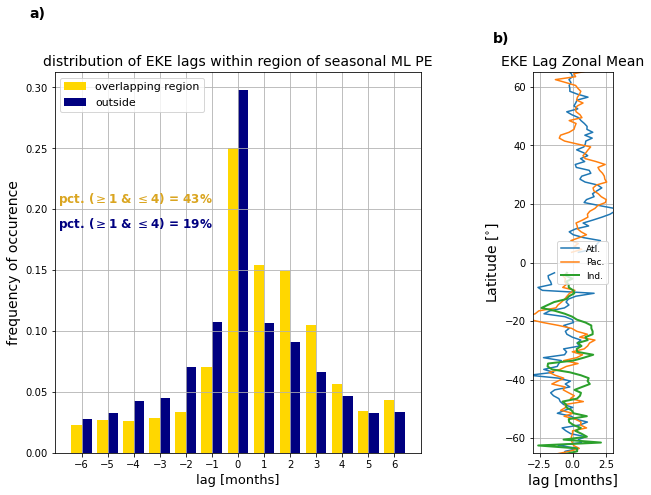

In [156]:
pe_lag_list = []
lag_list = []
outside_list = []
mo_lag_trim = np.transpose(mo_lag_ref[:,bi].copy())
# -- if desired, remove near equator values 
# lat_eq = np.where((pe_lat[bi] > -10) & (pe_lat[bi] < 10))[0]
# mo_lag_trim[:, lat_eq] = np.nan
# -- decide on what to do with nans 
# mo_lag_trim[np.isnan(mo_lag_trim)] = 0
for i in range(len(overlap_x)):
    lag_list.append(mo_lag_trim[overlap_x[i],overlap_y[i]])
    pe_lag_list.append(pe_eke_lag[overlap_x[i], overlap_y[i]])
for i in range(np.shape(test_m)[0]):
    if i < 1:
        outside_list = mo_lag_trim[i,test_m[i,:] < 1]
    else:
        outside_list = np.concatenate((outside_list, mo_lag_trim[i, test_m[i,:] < 1]))

        
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(10, 7))
gs = GridSpec(1, 6, figure=fig)
ax = fig.add_subplot(gs[:, 0:4])
ax2 = fig.add_subplot(gs[:, 5:])

# f, ax = plt.subplots()
ax.hist([lag_list, outside_list],bins=[-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7], \
        density=True,align='left', color=['#FFD700', '#000080'], label=['overlapping region', 'outside']) # [-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6]
# ax.hist(mo_lag_ref.flatten(),bins=np.arange(-10,10),density=True, align='right')
# ax.set_ylim([0, 10000])
ax.set_xticks(np.arange(-6,7,1))
# ax.set_xticks(np.arange(0,7,1))
# ax.set_xticklabels(np.arange(0,6,1))
handles, labels = ax.get_legend_handles_labels()
ll = ax.legend(handles, labels, fontsize=11,loc=2)
ax.grid()
ax.set_xlabel('lag [months]',fontsize=13)
ax.set_ylabel('frequency of occurence',fontsize=14)
ax.set_title('distribution of EKE lags within region of seasonal ML PE',fontsize=14)
in_lags = len(np.where((np.array([lag_list]) >= 1) & (np.array([lag_list]) <= 4))[0])/len(lag_list) # np.sum(~np.isnan(lag_list)) #
out_lags = len(np.where((np.array([outside_list]) >= 1) & (np.array([outside_list]) <= 4))[0])/len(outside_list)
ax.text(-6.9,.205,'pct. ($\geq$1 & $\leq$4) = ' + str(np.int(np.round(in_lags*100,0))) + '%',fontsize=12, color='#DAA520', fontweight='bold')
ax.text(-6.9,.185,'pct. ($\geq$1 & $\leq$4) = ' + str(np.int(np.round(out_lags*100,0))) + '%',fontsize=12, color='#000080', fontweight='bold')

atl_in = np.where((lon_bin_c > 290) & (lon_bin_c < 350))[0]
pac_in = np.where((lon_bin_c > 150) & (lon_bin_c < 240))[0]
ind_in = np.where((lon_bin_c > 60) & (lon_bin_c < 120))[0]
# atl_lat = np.where((lat_bin_c > 10))[0]
ind_lat = np.where(lat_bin_c < 0)[0]
ind_lat = np.where(lat_bin_c < 0)[0]
ax2.plot(np.nanmean(mo_lag[atl_in,:],axis=0),lat_bin_c, label='Atl.')
ax2.plot(np.nanmean(mo_lag[pac_in,:],axis=0),lat_bin_c, label='Pac.')
ax2.plot(np.nanmean(mo_lag[ind_in,:][:,ind_lat],axis=0),lat_bin_c[ind_lat], label='Ind.', linewidth=2)
ax2.legend(loc='middle left', fontsize=9)
ax2.set_xlim([-3,3])
ax2.set_ylim([-65, 65])
ax2.set_ylabel('Latitude [$^{\circ}$]', fontsize=14)
ax2.set_xlabel('lag [months]', fontsize=14)
ax2.set_title('EKE Lag Zonal Mean', fontsize=14)
ax2.grid()
ax.text(-8, 0.357, 'a)', fontweight='bold', fontsize=14)
ax2.text(-6, 75, 'b)', fontweight='bold', fontsize=14)
# fig.savefig('/Users/jakesteinberg/Desktop/cpt_manuscript_figures/r2/pct_lag_in_pe_regions_apeRate.jpg', dpi=500)

In [91]:
np.log10(1.5)

0.17609125905568124

In [41]:
np.nanmean(mo_lag[atl_in,:][:,atl_lat],axis=0)

array([-0.26415094,  0.22222222,  1.19642857,  0.7826087 ,  1.5106383 ,
        2.19512195,  2.8       ,  3.16666667,  3.12962963,  1.96363636,
        0.85714286,  1.03636364,  1.60714286,  1.49122807,  1.8245614 ,
        2.18965517,  1.86666667,  0.93220339,  0.54237288,  0.6779661 ,
        1.36363636,  1.24      ,  0.26923077,  0.19230769,  0.9       ,
        0.58823529,  1.12727273,  0.82352941,  0.29787234,  0.83673469,
        0.94827586,  0.98275862,  1.46551724,  0.9137931 ,  1.50877193,
        1.07017544,  1.08163265,  0.87755102,  0.62      ,  0.44      ,
       -0.06666667, -0.44897959,  0.37837838,  0.0952381 ,  0.22222222,
        0.32692308,  1.1509434 ,  0.36666667, -0.21666667, -0.21666667,
       -0.26666667, -0.13333333, -0.28070175, -0.01818182, -0.1       ,
       -0.37209302, -0.28947368,         nan,         nan,         nan])